# Multiple Domain Testing

## Mash Tests

In [1]:
import test_manifold_algorithms as tma
from MASH_MD import MASH
import matplotlib.pyplot as plt
import numpy as np

2024-09-11 18:02:45.947999: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 18:02:45.949136: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 18:02:45.954986: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 18:02:46.039248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 18:02:47.649369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

### Toy Data

In [2]:
d1 = np.random.randint(10, size = (3, 4))
d2 = np.random.randint(10, size = (3, 2))
d3 = np.random.randint(10, size = (3, 4))
d3

array([[9, 3, 7, 6],
       [6, 0, 3, 7],
       [6, 9, 8, 2]])

Time Data Below
 Time it took to execute the graph for domain 0:  0.10158
 Time it took to compute kernal 0:  3e-05
 Time it took to execute SGDM for domain 1:  0.00024
 Time it took to execute the graph for domain 1:  0.02771
 Time it took to execute the graph for domain 2:  0.02376
 Time it took to compute kernal 2:  2e-05
Length of weights to add: 6
Length of edges to add: 1
Length of edges to add: 1
Length of edges to add: 1
Length of edges to add: 1
Length of edges to add: 1
Length of edges to add: 1


/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:108: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(


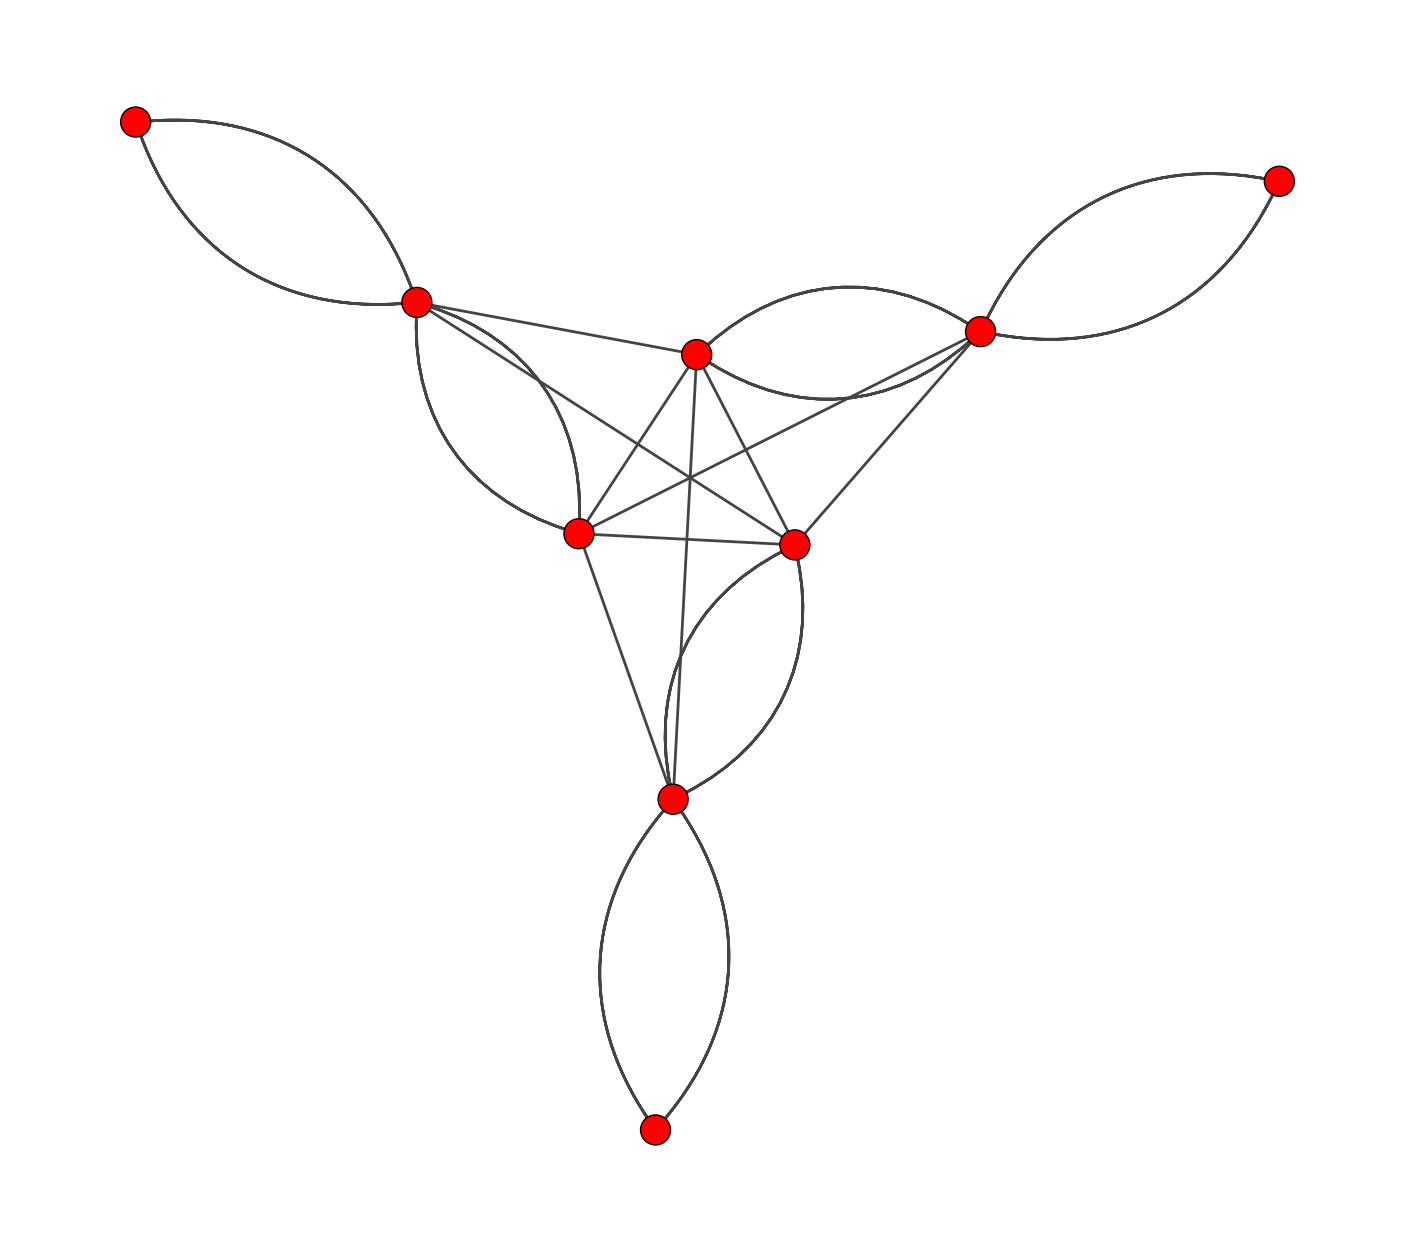

 Time it took to compute merge_graphs function:  0.2768
 Time it took to compute similarity_matrix function:  3e-05
Using optimal t value of 5
 Time it took to compute diffusion process:  0.00375
Fit process finished. We recommend calling optimize_by_creating_connections.


In [3]:
test = MASH(t = -1, knn = 2, distance_measures= ["default", "euclidean", "default"], verbose = 7)
test.fit([d1, d2, d3], np.array([[2, 2, 2]]))

### Actual data


In [4]:
dc0a = tma.test_manifold_algorithms("iris.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)
dc0b = tma.test_manifold_algorithms("seeds.csv", split = "distort", percent_of_anchors= [0.05], verbose = 5, random_state=42)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)

 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

MDS initialized with 7 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [5]:
md = MASH(t = -1, knn = 5, distance_measures= ["default", "euclidean", "default"], verbose = 7)

In [6]:
#Testing fit portions
md.domains = [dc0a.split_A, dc0b.split_B, dc0a.split_B]
md.domain_count = len(md.domains)
md.build_graphs()

 Time it took to execute the graph for domain 0:  0.0844
 Time it took to compute kernal 0:  0.00028
 Time it took to execute SGDM for domain 1:  0.00099
 Time it took to execute the graph for domain 1:  0.07855
 Time it took to execute the graph for domain 2:  0.0928
 Time it took to compute kernal 2:  0.00035


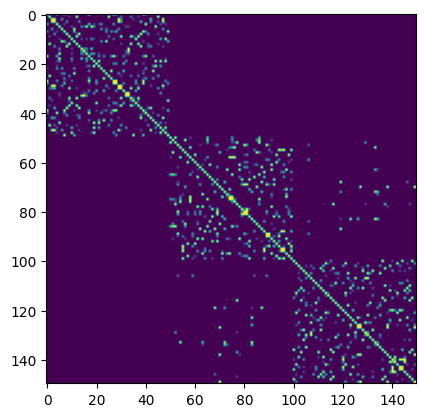

In [7]:
plt.imshow(md.kernals[0])

In [8]:
known_anchors = np.column_stack([dc0a.anchors[:, 0], dc0b.anchors[:150, 0], dc0a.anchors[:, 1]])
known_anchors[:4]

array([[ 28, 163,  28],
       [  6,  28,   6],
       [ 70,   6,  70],
       [ 62, 189,  62]])

In [9]:
#Ensure labels correspond to class
md.known_anchors = np.array([])
for anchors in known_anchors:
    if dc0a.labels[anchors[0]] == dc0b.labels[anchors[1]]:
        if len(md.known_anchors) < 1:
            md.known_anchors = anchors
        else:
            md.known_anchors = np.vstack([md.known_anchors, anchors])

md.known_anchors[-5:]

array([[127, 138, 127],
       [136, 134, 136],
       [119, 164, 119],
       [ 18,  14,  18],
       [ 95,  76,  95]])

In [10]:
dc0a.labels[[6, 57, 35]], dc0b.labels[[28,70,62]]

(array([1, 2, 1]), array([1, 2, 1]))

In [11]:
#Cache the lengths of the domains
md.len_domains = [len(domain) for domain in md.domains]
for length in md.len_domains:
    print(length)

150
199
150


In [12]:
md.known_anchors_adjusted = np.array(md.known_anchors)
for i, length in enumerate(md.len_domains):
    if i == len(md.domains) - 1:
        break
    else:
        md.known_anchors_adjusted += np.concatenate((np.repeat(0, i+1), np.repeat(length, len(md.domains)-(i+1))))
md.known_anchors_adjusted[:4], md.known_anchors[:4]

(array([[  6, 178, 355],
        [ 57, 220, 406],
        [ 35, 212, 384],
        [ 26, 207, 375]]),
 array([[ 6, 28,  6],
        [57, 70, 57],
        [35, 62, 35],
        [26, 57, 26]]))

Time Data Below
 Time it took to execute the graph for domain 0:  0.08065
 Time it took to compute kernal 0:  0.0001
 Time it took to execute SGDM for domain 1:  0.00063
 Time it took to execute the graph for domain 1:  0.2258
 Time it took to execute the graph for domain 2:  0.08499
 Time it took to compute kernal 2:  0.00014
Length of weights to add: 36
Length of edges to add: 6
Length of edges to add: 6
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 7
Length of edges to add: 7
Length of weights to add: 34
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 7
Length of edges to add: 7
Length of weights to add: 36
Length of edges to add: 5
Length of edges to add: 5
Length of edges to add: 8
Length of edges to add: 8
Length of edges to add: 5
Length of edges to add: 5
Length of weights to add: 48
Length of edges to add: 8
Length of edges to add: 8
Length of edges to add: 10
Length o

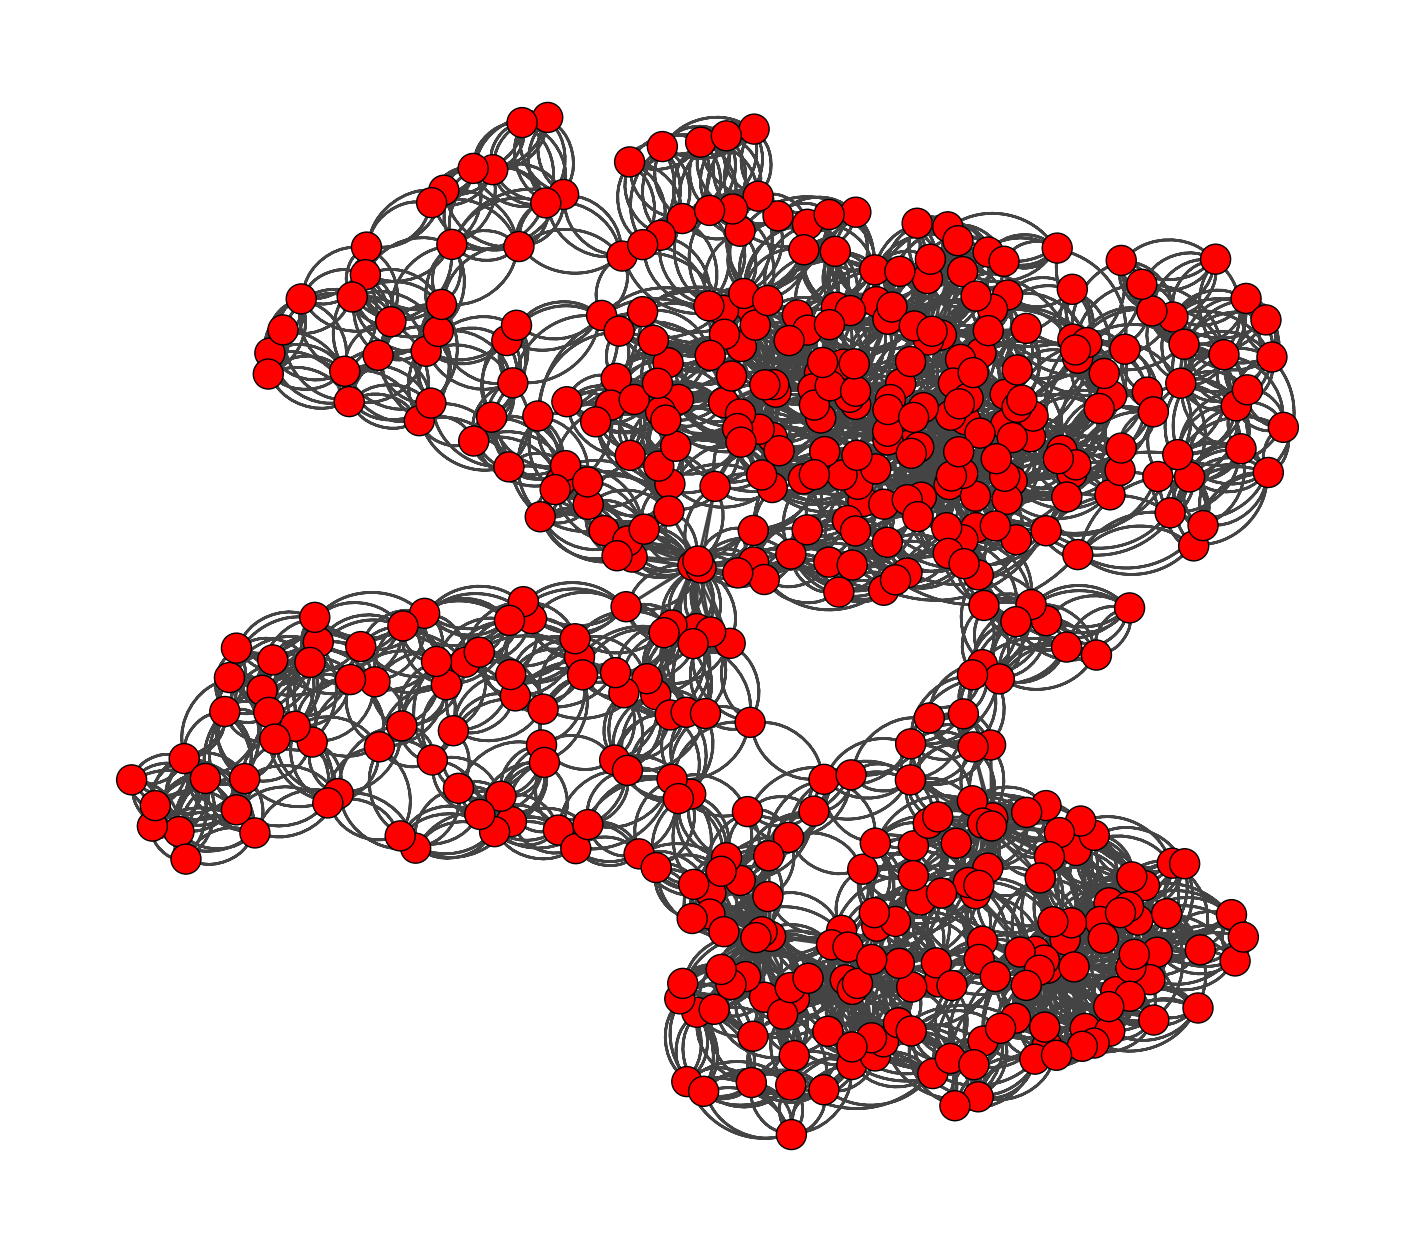

 Time it took to compute merge_graphs function:  7.67494
 Time it took to compute similarity_matrix function:  0.00151
Using optimal t value of 11
 Time it took to compute diffusion process:  0.62503
Fit process finished. We recommend calling optimize_by_creating_connections.


In [13]:
md.fit([dc0a.split_A, dc0b.split_B, dc0a.split_B], md.known_anchors[5:15])

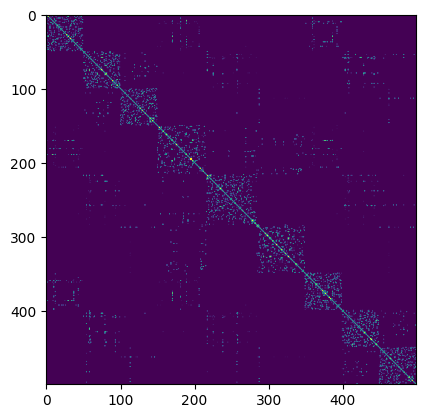

In [14]:
plt.imshow(md.graphAB)

In [15]:
sum(md.len_domains[:2]), md.len_domains

(349, [150, 199, 150])

In [16]:
# Sample list of lists
list_of_lists = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]

# Create the new list of strings
new_list = [f"domain {i+1}" for i, sublist in enumerate(list_of_lists) for _ in sublist]

print(new_list)

['domain 1', 'domain 1', 'domain 1', 'domain 2', 'domain 2', 'domain 3', 'domain 3', 'domain 3', 'domain 3']


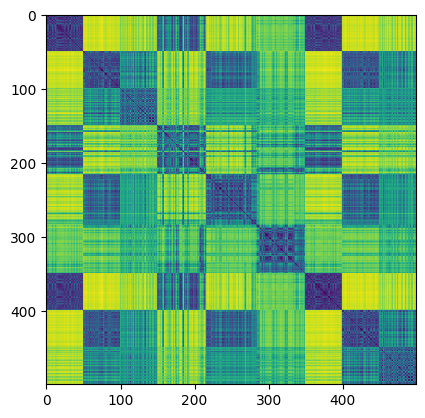

In [17]:
plt.imshow(md.int_diff_dist)

<Axes: >

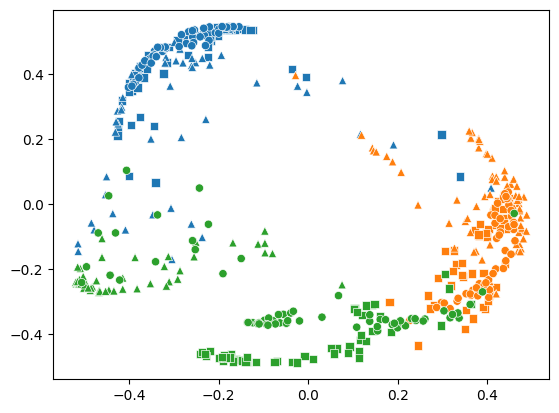

In [18]:
import seaborn as sns
import pandas as pd
from sklearn.manifold import MDS


#NOTE -> The coloring might be wrong on this graph
mds = MDS(metric=True, dissimilarity = 'precomputed', random_state = 42, n_components=2)
labels_tripled = np.concatenate([dc0a.labels, dc0b.labels, dc0a.labels])
emb1 = mds.fit_transform(md.int_diff_dist)
styles = ['Graph1' if i < len(emb1[:]) / 3 else 'Graph2' if i < len(emb1[:]) * (2 / 3) else "Graph3" for i in range(len(emb1[:]))]

sns.scatterplot(legend = False, x = emb1[:, 0], y = emb1[:, 1], hue = pd.Categorical(labels_tripled), style = styles, markers = {"Graph1": 's', "Graph2": "^", "Graph3": "o"})

(150, 2)
(199, 2)
(150, 2)


/tmp/ipykernel_773168/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


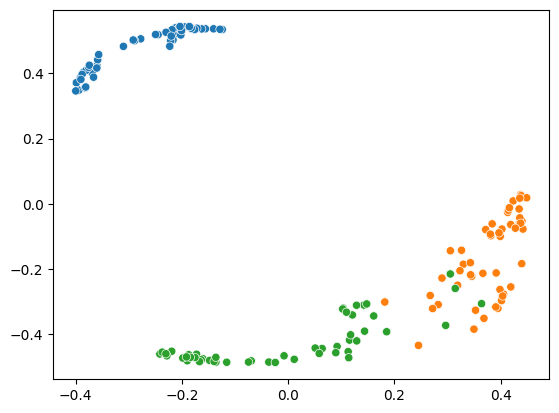

/tmp/ipykernel_773168/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


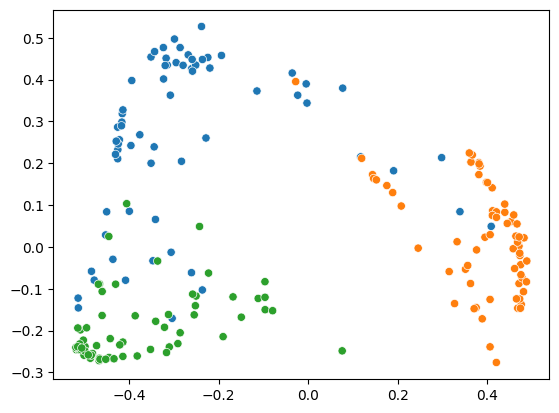

/tmp/ipykernel_773168/1063771587.py:11: UserWarning: 
The markers list has fewer values (1) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))


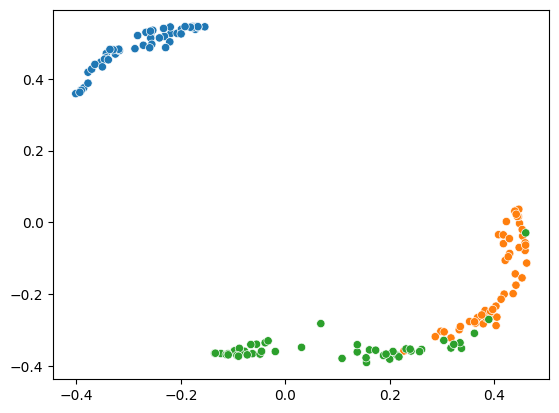

In [19]:
#Sort out the embedding by domains
embeddings = [emb1[:md.len_domains[0], :]]
print(embeddings[0].shape)

for i in range(1, md.domain_count):
    embeddings.append(emb1[sum(md.len_domains[:i]):sum(md.len_domains[:i+1]),:])
    print(embeddings[i].shape)


for emb, labels in zip(embeddings, [dc0a.labels, dc0b.labels, dc0a.labels]):
    sns.scatterplot(legend = False, x = emb[:, 0], y = emb[:, 1], style = labels, markers = "o", hue = pd.Categorical(labels))
    plt.show()

Scores from domain 1 to 2: 
    Cross Embedding: 0.916465661641541
    Can't compute FOSCTTM with different domain shapes. Domain 1: (150, 4). Domain 2: (199, 7)
Scores from domain 1 to 3: 
    Cross Embedding: 0.9266666666666666
    Can't compute FOSCTTM with different domain shapes. Domain 1: (150, 4). Domain 3: (150, 4)
Scores from domain 2 to 3: 
    Cross Embedding: 0.8789782244556115
    FOSCTTM: 0.0


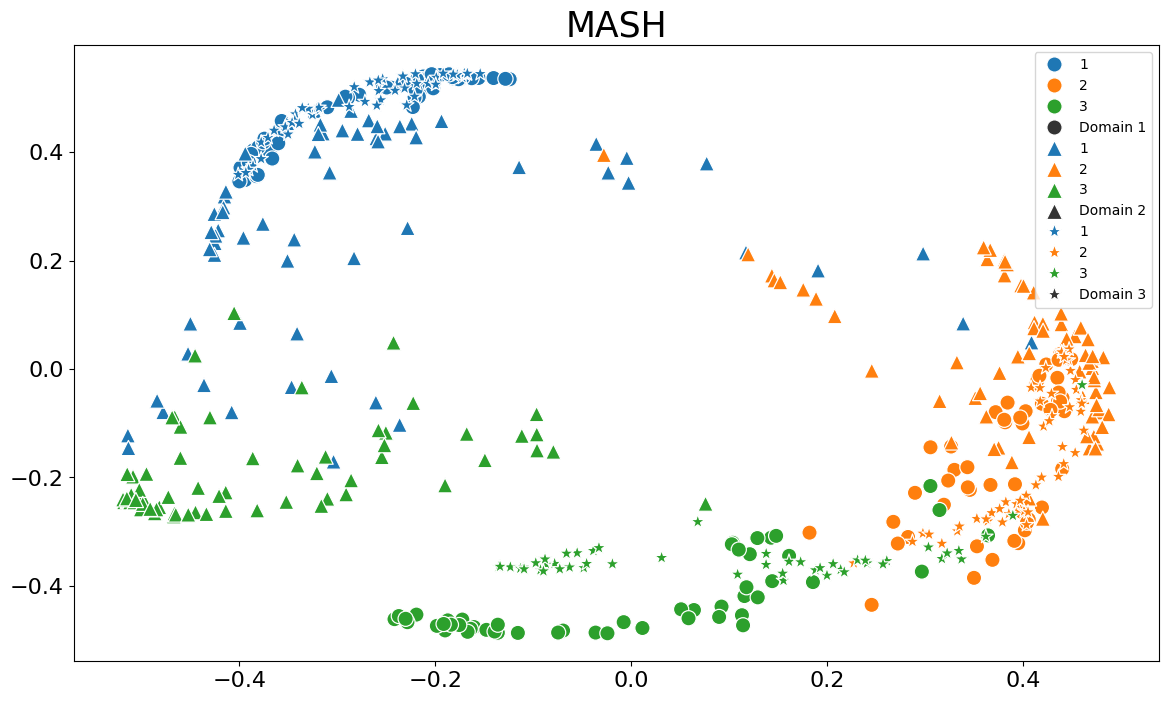

In [20]:
md.plot_emb([dc0a.labels, dc0b.labels, dc0a.labels], n_comp = 2)

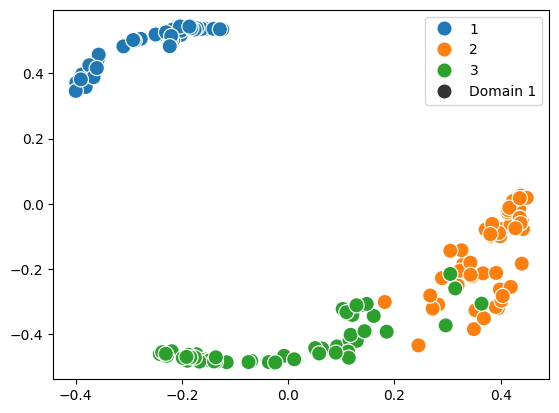

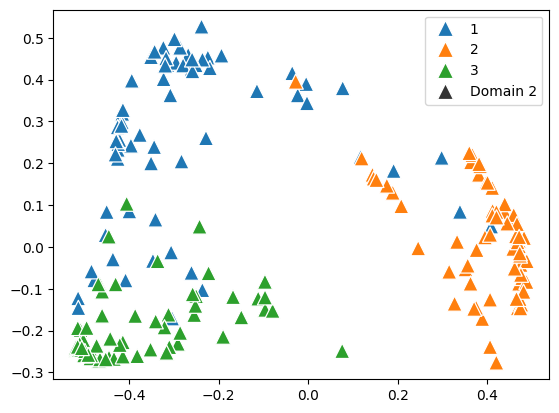

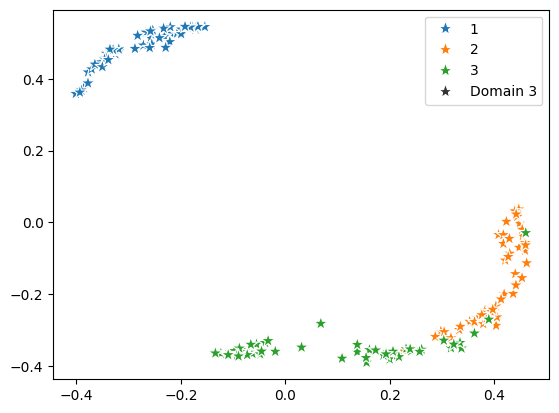

In [21]:
md.plot_all_embeddings([dc0a.labels, dc0b.labels, dc0a.labels])